In [272]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.path import Path
from ripser import ripser
from persim import plot_diagrams
from collections import defaultdict
from scipy.optimize import curve_fit
import re

# 1) Generating the Sierpinski triangle/carpet

In [273]:
def sierpinski(points, degree):
    
    # Base case: return the input points if the degree is 0
    if degree == 0:
        return points
    
    # Recursive case: divide the triangle into four smaller triangles
    # and remove the center triangle
    p1, p2, p3 = points
    p12 = (p1 + p2) / 2
    p23 = (p2 + p3) / 2
    p31 = (p3 + p1) / 2
    sierpinski_points = np.vstack([
        sierpinski(np.array([p1, p12, p31]), degree - 1),
        sierpinski(np.array([p2, p23, p12]), degree - 1),
        sierpinski(np.array([p3, p31, p23]), degree - 1)
    ])
    
    return sierpinski_points

def get_last_index(distances):
    idx = np.where(distances < np.sqrt(3)/2)[0]
    if len(idx) > 0:
        last_index = idx[-1]
    else:
        last_index = None
    return last_index

def get_distances_and_sorted_points(points):
    distances = np.linalg.norm(points, axis=1)
    sorted_points = points[np.argsort(distances)]
    return distances, sorted_points



def triangular_lattice(length, n, side_length):
    scale = side_length / (n * length + length/2)
    points = []
    for i in range(n+1):
        for j in range(n-i+1):
            x = scale * (i*length + j*length/2)
            y = scale * j*np.sqrt(3)/2*length
            points.append([x, y])
    return np.array(points)

#length_threshold = distances[1]*0.9
def get_holes(triangular_lattice_points, sorted_points, length_threshold):
    # Compute the minimum distance between each point in the triangular lattice and the Sierpinski triangle
    tri_distances = np.sqrt(np.min(np.sum((triangular_lattice_points[:, np.newaxis, :] - sorted_points)**2, axis=2), axis=1))
    
    # Find the indices of the points in the triangular lattice that are not in the Sierpinski triangle
    idx = np.where(tri_distances >= length_threshold)[0]

    # Check if idx is empty before using it to index tri_points
    if len(idx) > 0:
        hole_points = triangular_lattice_points[idx]
    else:
        hole_points = np.array([])
    return hole_points

def order(dgm1): 
    l = list(dgm1)
    l.sort(key=lambda coord: (coord[1] - coord[0])/coord[0])
    arr = np.array(l)
    return(arr)

def sierpinski_carpet(size, generation):
    points = []
    origin = (0, 0)  # Bottom left corner of the initial square
  
    def generate_points(x, y, size, generation):
        if generation == 0:
            # Base case: Add all four corners of the square
            points.append([x, y])
            points.append([x + size, y])
            points.append([x, y + size])
            points.append([x + size, y + size])
        else:
            # Recursive case: Divide into 9 squares and add points for non-shaded squares
            new_size = size / 3
            for i in range(3):
                for j in range(3):
                    if not (i == 1 and j == 1):
                        new_x = x + i * new_size
                        new_y = y + j * new_size
                        generate_points(new_x, new_y, new_size, generation - 1)

    generate_points(*origin, size, generation)
    return np.array(points)

#Do not work with the smallest H1, because they are 'the start'
def fractal_dimension_from_tda(order_dgm1):
    unique_y_coord_counter = defaultdict(int)
    for i, arr in enumerate(order_dgm1):
        unique_y_coord_counter[arr[1]] += 1
    first_used_key = list(unique_y_coord_counter.keys())[1]
    second_used_key = list(unique_y_coord_counter.keys())[2]
    scaling_factor = second_used_key/first_used_key
    number_idenical_copies_factor = unique_y_coord_counter[first_used_key]/unique_y_coord_counter[second_used_key]
    return np.log(number_idenical_copies_factor)/np.log(scaling_factor)

2187


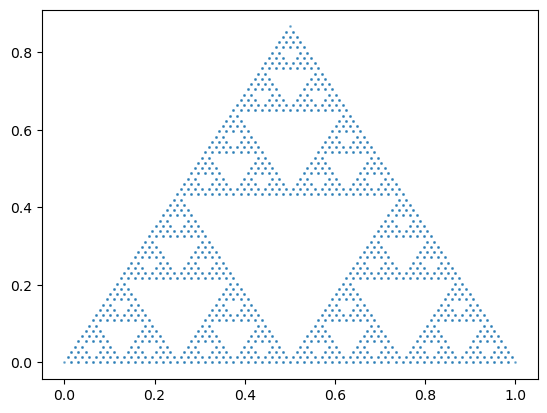

In [274]:
triangle = sierpinski(np.array([[0, 0], [1, 0], [0.5, 0.866]]), 6)
print(len(triangle))
plt.scatter(triangle[:, 0], triangle[:, 1], s=1, alpha = 0.5, label='Sierpinski Triangle')
plt.show()

In [275]:
p=2
size = 100
generation = 3

# Generate the list of points
points = sierpinski(np.array([[0, 0], [1, 0], [0.5, 0.866]]), 6) #sierpinski_carpet(size, generation), sierpinski(np.array([[0, 0], [1, 0], [0.5, 0.866]]), 6)
result = ripser(points)

(606, 2)


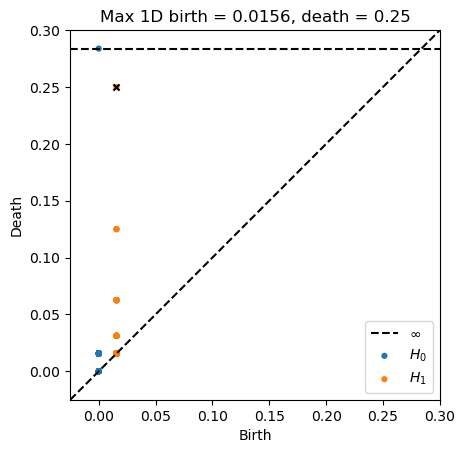

In [276]:
diagrams = result['dgms']
cocycles = result['cocycles']
D = result['dperm2all']
dgm1 = diagrams[1]
print(dgm1.shape)
order_dgm1 = order(dgm1)
idx = np.argmax((dgm1[:, 1] - dgm1[:, 0])/dgm1[:, 0]) 
plot_diagrams(diagrams, show = False)
plt.scatter(dgm1[idx, 0], dgm1[idx, 1], 20, 'k', 'x')
plt.title("Max 1D birth = %.3g, death = %.3g"%(dgm1[idx, 0], dgm1[idx, 1]))
plt.show()

In [277]:
unique_y_coord_counter = defaultdict(int)
for i, arr in enumerate(order_dgm1):
    unique_y_coord_counter[arr[1]] += 1
print(unique_y_coord_counter)

defaultdict(<class 'int'>, {0.015625: 566, 0.03125: 27, 0.0625: 9, 0.125: 3, 0.25: 1})


In [278]:
fractal_dimension_from_tda(order_dgm1)

1.5849625007211563

In [279]:
# Define the function to fit
def func(x, a, b):
    return a * np.power(x, b)

def prepare_data(distances):#prepares the xdata as the indices (k in thesis) and the ydata is the distances corresponding to that k (R_k in thesis)
    distances = distances[np.argsort(distances)]
    indices = np.indices((1, distances.shape[0]))[1]
    k = indices.ravel()
    R_k = np.array(distances)
    return k, R_k

def do_everything(option):
    sierp_points = sierpinski(np.array([[0, 0], [1, 0], [0.5, 0.866]]), 8)
    sierp_distances, sierp_sorted_points = get_distances_and_sorted_points(sierp_points)
    placeholder, sorted_distances = prepare_data(sierp_distances)
    if option == 'tl':
        points = triangular_lattice(sorted_distances[1],300, 1)
        plt.scatter(points[:,0], points[:,1], s=1, alpha=0.5, label='Triangular Lattice')
        plt.xlabel('x')
        plt.ylabel('y')
        #plt.savefig(r"C:\Users\Lenovo\master\thesis\Python_plots\triangular_lattice.png")
        plt.show()
        distances, sorted_points = get_distances_and_sorted_points(points)
        k, R_k = prepare_data(distances)
        last_idx = get_last_index(R_k)
        k, R_k = k[:last_idx], R_k[:last_idx]
    if option == 'st':
        points = sierp_points
        plt.scatter(points[:, 0], points[:, 1], s=1, alpha = 0.5, label='Sierpinski Triangle')
        plt.xlabel('x')
        plt.ylabel('y')
        #plt.savefig(r"C:\Users\Lenovo\master\thesis\Python_plots\sierpinski_triangle_degree8.png")
        plt.show()
        k, R_k = prepare_data(sierp_distances)
        last_idx = get_last_index(R_k)
        k, R_k = k[:last_idx], R_k[:last_idx]
    if option == 'sh':
        triangularlattice = triangular_lattice(sorted_distances[1],200, 1)
        points = get_holes(triangularlattice, sierp_sorted_points, sorted_distances[1]*0.9)
        plt.scatter(points[:, 0], points[:, 1], s=1, alpha = 0.5, label='Holes of the Sierpinski Triangle')
        plt.show()
        distances, sorted_points = get_distances_and_sorted_points(points)
        k, R_k = prepare_data(distances)
        last_idx = get_last_index(R_k)
        k, R_k = k[:last_idx], R_k[:last_idx]
    """  
    def func(x, a, b):
        return a * np.power(x, b)
    """  
    print(f'Last used idx: {last_idx} with corresponding distance: {R_k[-1]}')
    def func(x, a, b):
        return a*x + b
    #def func_fixed_a(x, b):
    #    return sorted_distances[1]*np.power(x, b)
    popt, pcov = curve_fit(func, np.log(k[80:]), np.log(R_k[80:]))
    # Generate some x values for the fitted function
    xfit = np.linspace(np.log(k[80:]).min(), np.log(k[80:]).max(), 100)

    # Generate the y values for the fitted function using the optimal values for a and b
    yfit = func(xfit, *popt)
    # Plot the data and the fitted function on the same plot
    print(f'The fitted scaling factor: {np.exp(popt[1])}', f'The lattice spacing: {sorted_distances[1]}', f'Reciprocal power:{1/popt[0]}')
    plt.scatter(np.log(k[80:]), np.log(R_k[80:]),s=1, label='Sierpinski triangle points')
    plt.plot(xfit, yfit, label=f'{round(popt[0], 3)}x + {round(popt[1], 3)}', color='r')
    plt.xlabel('ln(k)')
    plt.ylabel('ln(R_k)')
    plt.legend()
    #plt.savefig(r"C:\Users\Lenovo\master\thesis\Python_plots\triangular_lattice_fit.png")
    plt.show()
    
    return points, popt, sorted_distances[1]

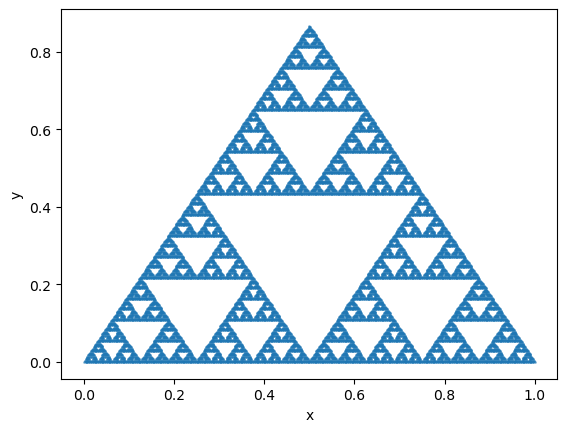

Last used idx: 16360 with corresponding distance: 0.8660222063631293
The fitted scaling factor: 0.002028446684024283 The lattice spacing: 0.0039061640615546665 Reciprocal power:1.5890332178350663


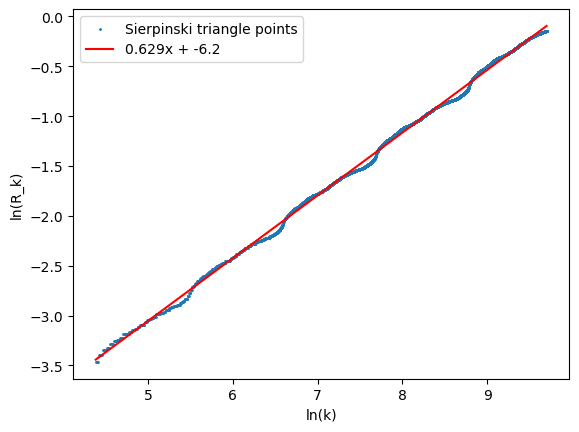

In [329]:
points, popt, lattice_spacing = do_everything('st') #tl = triangular lattice, st = sierpinski triangle, sh = sierpinski holes

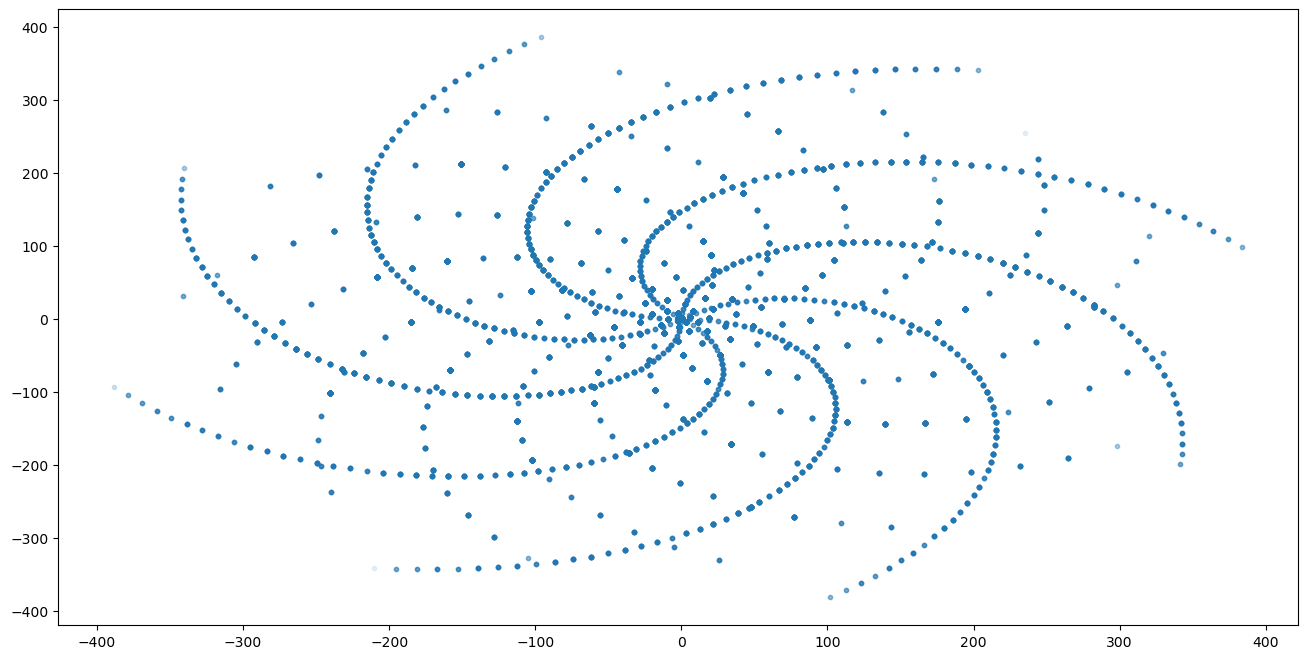

In [332]:
scaling_factor = 400 #changing this will change the plot (you can play around with this) 
x_data, y_data = get_coordinate(points*scaling_factor)
plt.figure(figsize=(16,8))
plt.scatter(x_data, y_data, marker='.', alpha=0.1)
plt.show()

1) When playing with some of the above values of the scaling factor (e.g. 120), I got a plot that reminded me of the plot of prime numbers in polar coordinates. Is there a connection between fractals and prime numbers?

2) Taking the scaling_factor = 400, gives two distinct spirals going, cleanly separated. Is this maybe adecomposition of two distinct periodisities in the input points?

In [307]:
"""Code taken from: https://stackoverflow.com/questions/567222/simple-prime-number-generator-in-python"""
def isprime(n):
    return re.compile(r'^1?$|^(11+)\1+$').match('1' * n) is None

primes = [x for x in range(10000) if isprime(x)]

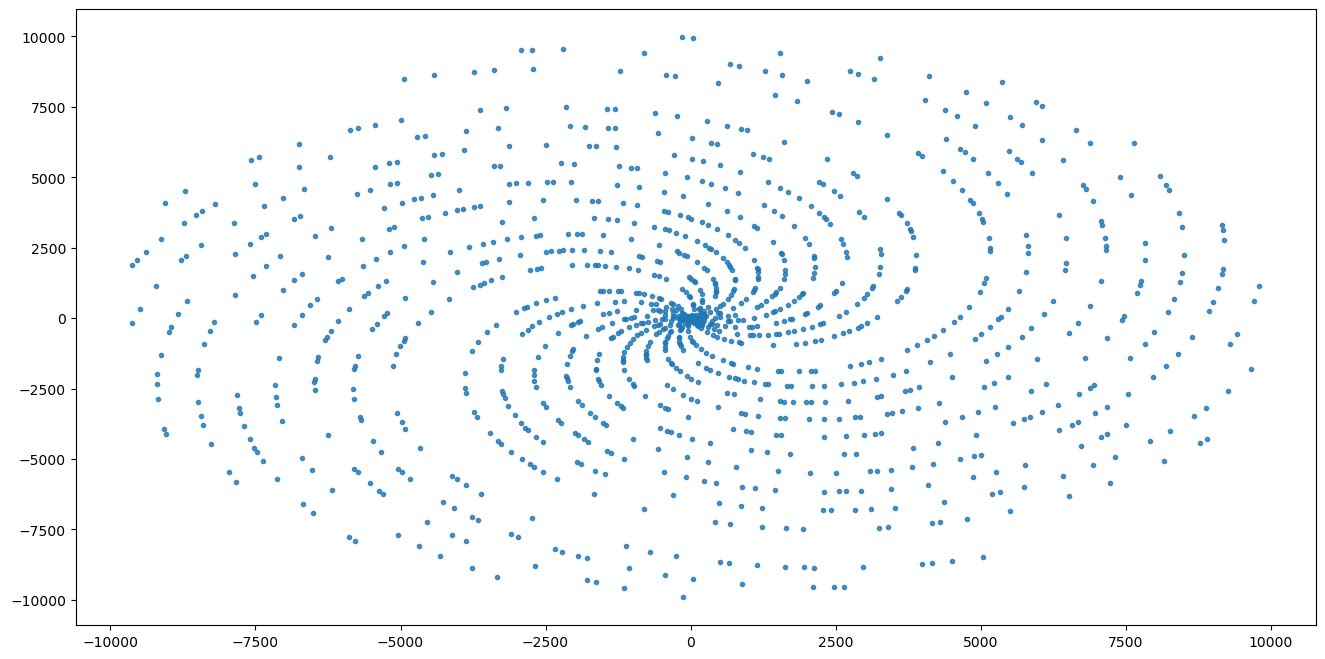

In [313]:
#For a more clear picture, https://math.stackexchange.com/questions/885879/meaning-of-rays-in-polar-plot-of-prime-numbers
x_data, y_data = get_coordinate(primes)
plt.figure(figsize=(16,8))
plt.scatter(x_data, y_data, marker='.', alpha=0.8)
plt.show()

In [287]:
def circle_density(points, r):
    # Count the number of points within a circle of radius r
    num_points = np.sum(np.linalg.norm(points, axis=1) < r)

    # Compute the area of the circle
    area = (np.pi/6) * r**2

    # Compute the density as the number of points within the circle
    # divided by the area of the circle
    density = num_points / area

    return density

def lacunarity(R_k, points):
    # Compute the sequence of circle densities for radii
    # equal to the ordered distances R_k
    densities = []
    for r in R_k:
        density = circle_density(points, r)
        densities.append(density)
    mean_density = np.mean(densities)
    relative_densities = densities/mean_density
    #plt.plot(R_k, relative_densities)
    def func(x, a, b):
        return a*x + b
    popt, pcov = curve_fit(func, np.log(R_k), np.log(relative_densities))
    # Generate some x values for the fitted function
    xfit = np.linspace(np.log(R_k.min()), np.log(R_k.max()), 100)
    
    # Generate the y values for the fitted function using the optimal values for a and b
    yfit = func(xfit, *popt)
    # Plot the data and the fitted function on the same plot
    plt.scatter(np.log(R_k), np.log(relative_densities),s=1, label='Data')
    plt.plot(xfit, yfit, label=f'Fit{popt[0]}x^{popt[1]}', color='r')
    plt.xlabel('ln(R_k)')
    plt.ylabel('ln of Relative Densities')
    plt.legend()
    plt.show()
    # Compute the mean and variance of the sequence of densities
    
    var_density = np.var(densities)

    # Compute the lacunarity as the variance of the densities
    # divided by the square of the mean density
    lacunarity = var_density / mean_density**2

    return lacunarity

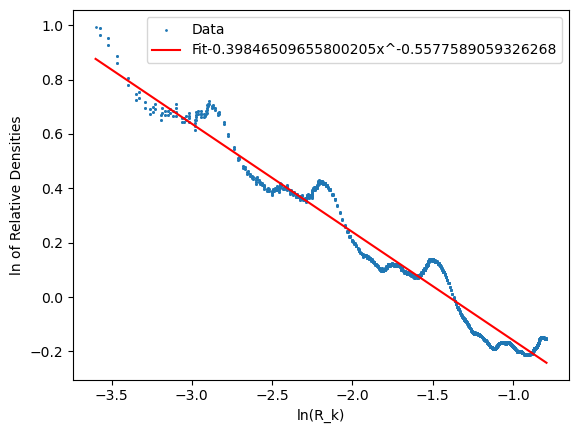

In [288]:
distances, sorted_points = get_distances_and_sorted_points(points)
k, R_k = prepare_data(distances)
k, R_k = k[70:6000], R_k[70:6000] # remove the initial and final points since they are not 'fully' part of the fractal
l = lacunarity(R_k, points)

In [289]:
STE = SingleTakensEmbedding(parameters_type='search', dimension=3,
                            time_delay=10)
R_k_embedded = STE.fit_transform(np.log(R_k))
print('Optimal time delay based on mutual information:',
      STE.time_delay_)
print('Optimal embedding dimension based on false nearest neighbors:',
      STE.dimension_)


Optimal time delay based on mutual information: 9
Optimal embedding dimension based on false nearest neighbors: 2


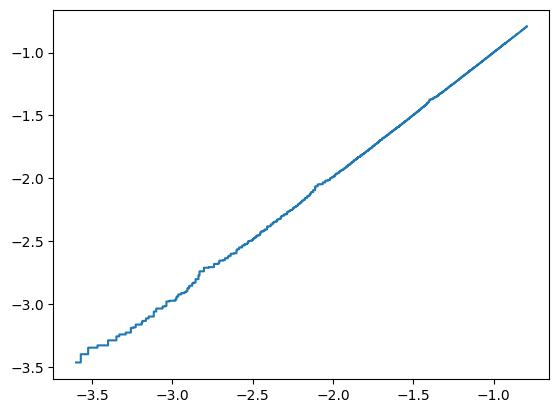

In [290]:
plt.plot(R_k_embedded[:,0], R_k_embedded[:,1])

In [291]:
def do_everything_2(option):
    sierp_points = sierpinski(np.array([[0, 0], [1, 0], [0.5, 0.866]]), 8)
    sierp_distances, sierp_sorted_points = get_distances_and_sorted_points(sierp_points)
    placeholder, sorted_distances = prepare_data(sierp_distances)
    if option == 'tl':
        points = triangular_lattice(sorted_distances[1],300, 1)
        plt.scatter(points[:,0], points[:,1], s=1, alpha=0.5, label='Triangular Lattice')
        plt.show()
        distances, sorted_points = get_distances_and_sorted_points(points)
        k, R_k = prepare_data(distances)
        last_idx = get_last_index(R_k)
        k, R_k = k[:last_idx], R_k[:last_idx]
    if option == 'st':
        points = sierp_points
        plt.scatter(points[:, 0], points[:, 1], s=1, alpha = 0.5, label='Sierpinski Triangle')
        plt.show()
        distances, sorted_points = get_distances_and_sorted_points(points)
        k, R_k = prepare_data(distances)
        last_idx = get_last_index(R_k)
        k, R_k = k[:last_idx], R_k[:last_idx]
    if option == 'sh':
        triangularlattice = triangular_lattice(sorted_distances[1],200, 1)
        points = get_holes(triangularlattice, sierp_sorted_points, sorted_distances[1]*0.9)
        
        plt.scatter(points[:, 0], points[:, 1], s=1, alpha = 0.5, label='Holes of the Sierpinski Triangle')
        plt.show()
        distances, sorted_points = get_distances_and_sorted_points(points)
        k, R_k = prepare_data(distances)
        last_idx = get_last_index(R_k)
        k, R_k = k[:last_idx], R_k[:last_idx]
        
    def func(x, a):
        return a*x + np.log(sorted_distances[1])
    #def func_fixed_a(x, b):
    #    return sorted_distances[1]*np.power(x, b)
    popt, pcov = curve_fit(func, np.log(k[80:]), np.log(R_k[80:]))
    # Generate some x values for the fitted function
    xfit = np.linspace(np.log(k[80:]).min(), np.log(k[80:]).max(), 100)

    # Generate the y values for the fitted function using the optimal values for a and b
    yfit = func(xfit, *popt)
    # Plot the data and the fitted function on the same plot

    print(f'The lattice spacing: {sorted_distances[1]}', f'Reciprocal power:{1/popt[0]}')
    plt.scatter(np.log(k[80:]), np.log(R_k[80:]),s=1, label='Data')
    plt.plot(xfit, yfit, label=f'Fit{popt[0]}x', color='r')
    plt.xlabel('k')
    plt.ylabel('R_k')
    plt.legend()
    plt.show()
    return points, popt, sorted_distances[1]

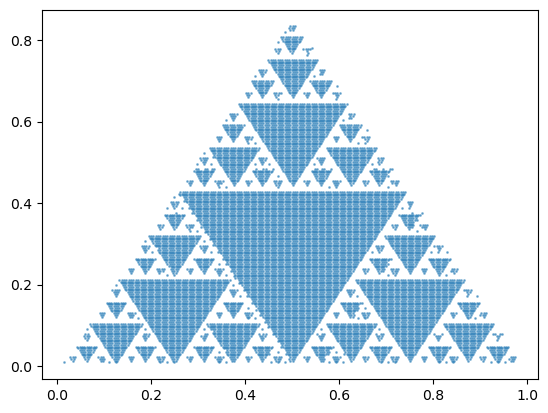

The lattice spacing: 0.0039061640615546665 Reciprocal power:1.7070937928269745


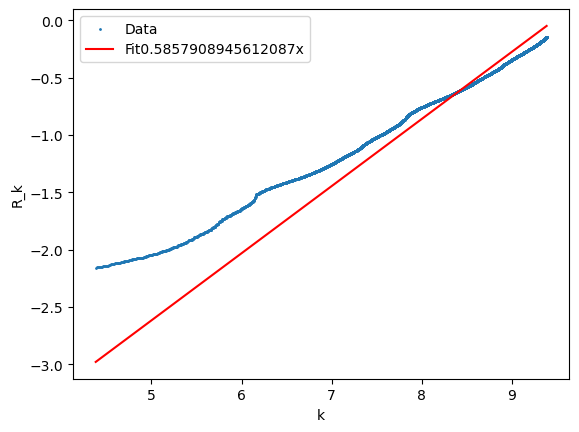

In [322]:
points, popt, lattice_spacing = do_everything_2('sh') #tl = triangular lattice, st = sierpinski triangle, sh = sierpinski holes

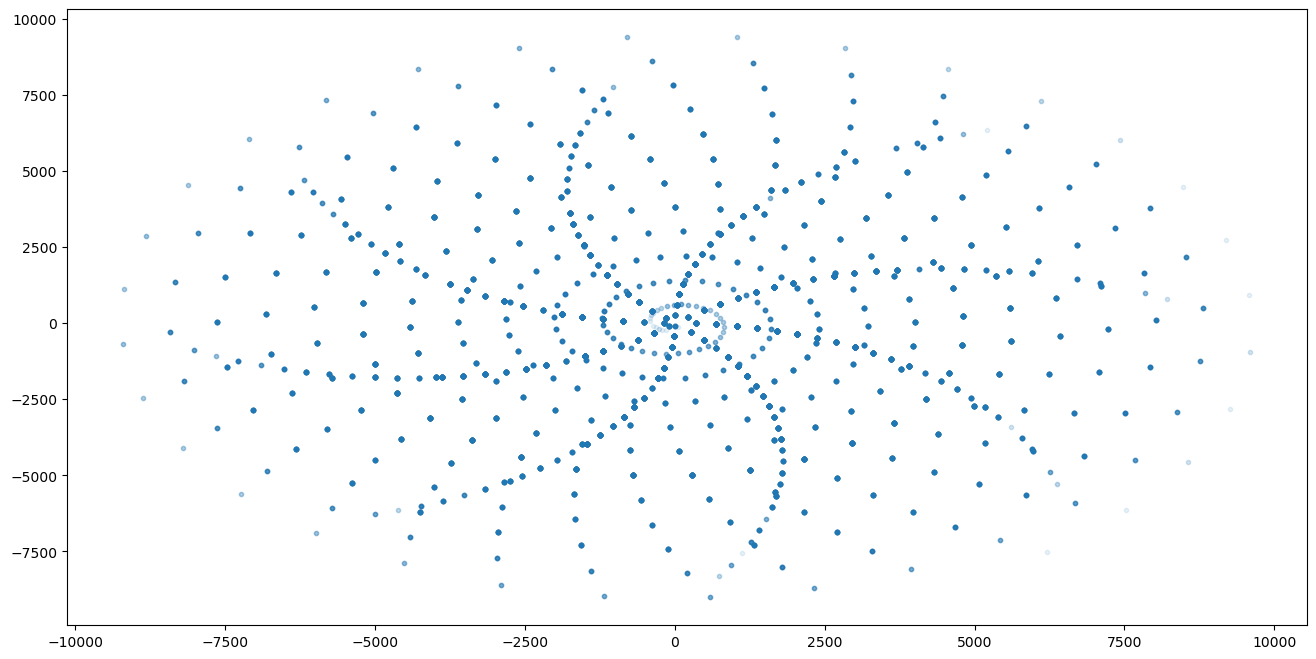

In [328]:
scaling_factor = 10000
x_data, y_data = get_coordinate(points*scaling_factor)
plt.figure(figsize=(16,8))
plt.scatter(x_data, y_data, marker='.', alpha=0.1)
plt.show()

# Now sierpinski carpet: problem: it seems to not give the fractal dimension

In [137]:
squares = sierpinski_carpet(size=1, generation=4)

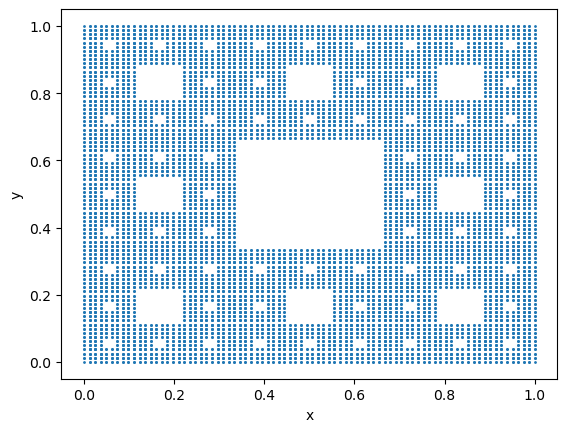

In [138]:
plt.scatter(squares[:, 0], squares[:, 1], s=1)
plt.xlabel('x')
plt.ylabel('y')
plt.show()

In [139]:
def generate_lattice(min_spacing):
    x, y = np.meshgrid(np.arange(0, 1+min_spacing, min_spacing), np.arange(0, 1+min_spacing, min_spacing))
    # Remove any points outside the square
    x, y = x.flatten(), y.flatten()
    keep = np.logical_and(x >= 0, x <= 1)
    keep = np.logical_and(keep, y >= 0)
    keep = np.logical_and(keep, y <= 1)
    x, y = x[keep], y[keep]
    return np.column_stack((x,y))


In [140]:
dis, sort = get_distances_and_sorted_points(squares)
placeholder, sorted_distances = prepare_data(dis)

In [141]:
sq = generate_lattice(sorted_distances[1])
sq_dis, sq_sort = get_distances_and_sorted_points(sq)

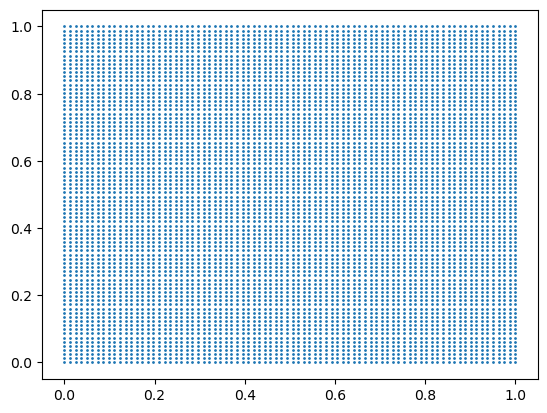

In [142]:
plt.scatter(sq[:, 0], sq[:, 1], s=1, alpha = 1)
plt.show()

In [143]:
holes = get_holes(sq, squares, sorted_distances[1])

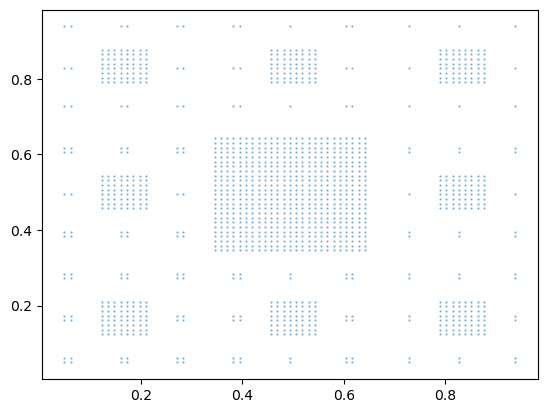

In [144]:
plt.scatter(holes[:, 0], holes[:, 1], s=0.4, alpha = 0.5)

In [145]:
dis_holes, sort_holes = get_distances_and_sorted_points(holes)

The fitted scaling factor: 0.0058524078521316495 The lattice spacing: 0.012345679012345678 Reciprocal power:1.8249001620597953


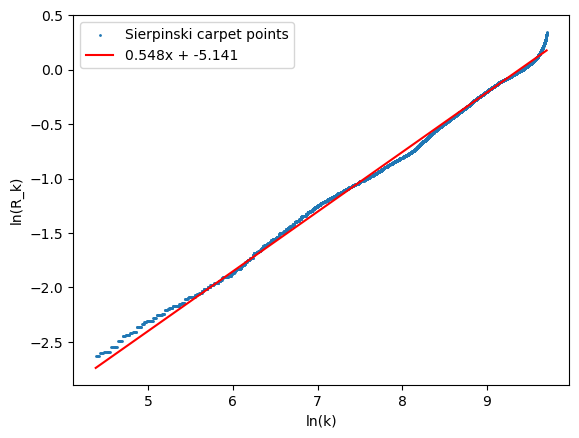

In [146]:
k, R_k = prepare_data(dis) #NEED TO REMOVE THE LAST PARTS FOR A BETTER FIT
k, R_k = k[:60000], R_k[:60000] 

def func(x, a, b):
    return a*x + b
#def func_fixed_a(x, b):
#    return sorted_distances[1]*np.power(x, b)
popt, pcov = curve_fit(func, np.log(k[80:]), np.log(R_k[80:]))
# Generate some x values for the fitted function
xfit = np.linspace(np.log(k[80:]).min(), np.log(k[80:]).max(), 100)

# Generate the y values for the fitted function using the optimal values for a and b
yfit = func(xfit, *popt)
# Plot the data and the fitted function on the same plot
print(f'The fitted scaling factor: {np.exp(popt[1])}', f'The lattice spacing: {sorted_distances[1]}', f'Reciprocal power:{1/popt[0]}')
plt.scatter(np.log(k[80:]), np.log(R_k[80:]),s=1, label='Sierpinski carpet points')
plt.plot(xfit, yfit, label=f'{round(popt[0], 3)}x + {round(popt[1], 3)}', color='r')
plt.xlabel('ln(k)')
plt.ylabel('ln(R_k)')
plt.legend()
#plt.savefig(r"C:\Users\Lenovo\master\thesis\Python_plots\sierpinski_capet_degree7_Rk_fits_log.png")
plt.show()

(1043, 2)


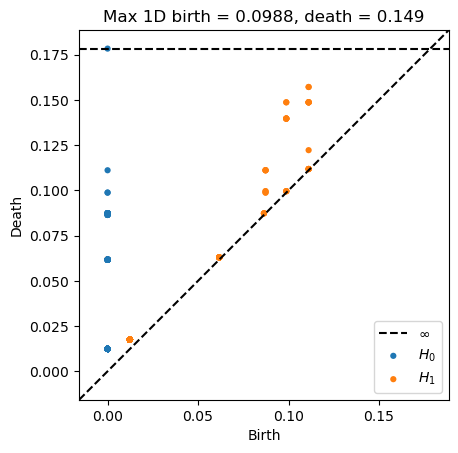

In [147]:
result = ripser(holes)
diagrams = result['dgms']
cocycles = result['cocycles']
D = result['dperm2all']
dgm1 = diagrams[1]
dgm0 = diagrams[0]
print(dgm1.shape)
order_dgm1 = order(dgm1)
idx = np.argmax((dgm1[:, 1] - dgm1[:, 0])/dgm1[:, 0]) 
plot_diagrams(diagrams, show = False)
#plt.scatter(dgm1[idx, 0], dgm1[idx, 1], 20, 'k', 'x')
plt.title("Max 1D birth = %.3g, death = %.3g"%(dgm1[idx, 0], dgm1[idx, 1]))
plt.show()

In [148]:
unique_y_coord_counter = defaultdict(int)
for i, arr in enumerate(dgm0):
    unique_y_coord_counter[arr[1]] += 1
print(unique_y_coord_counter)

defaultdict(<class 'int'>, {0.012345679104328156: 1220, 0.06172839552164078: 38, 0.08641975373029709: 6, 0.08729713410139084: 25, 0.09876543283462524: 2, 0.1111111119389534: 1, inf: 1})


In [149]:
keys = list(unique_y_coord_counter.keys())

In [150]:
# interesting numbers
print(keys[1]/keys[0])
print(keys[2]/keys[1])
for i in range(len(keys)-1):
    print(i, keys[i+1]/keys[i])
    print(i, keys[i]/keys[i+1])
    print('-------------------------')


5.0
1.4
0 5.0
0 0.2
-------------------------
1 1.4
1 0.7142857142857143
-------------------------
2 1.0101525442184425
2 0.9899494939882595
-------------------------
3 1.1313708502722966
3 0.8838834761911372
-------------------------
4 1.125
4 0.8888888888888888
-------------------------
5 inf
5 0.0
-------------------------


# Box Counting dimension

In [151]:
def box_counting_dimension(points, box_sizes):
    # Calculate the minimum and maximum coordinates of the points
    xmin, ymin = np.min(points, axis=0)
    xmax, ymax = np.max(points, axis=0)
    
    # Calculate the number of points in each box for each box size
    counts = []
    for size in box_sizes:
        xbins = np.arange(xmin, xmax+size, size)
        ybins = np.arange(ymin, ymax+size, size)
        hist, _, _ = np.histogram2d(points[:,0], points[:,1], bins=(xbins, ybins))
        counts.append(np.sum(hist > 0))
    
    # Plot the number of boxes that contain at least one point as a function of box size
    plt.loglog(box_sizes, counts, 'o')
    plt.xlabel('Box size')
    plt.ylabel('Number of boxes')
    
    # Fit a power-law function to the data and return the exponent (box counting dimension)
    def power_law(x, a, b):
        return a * x**b
    popt, _ = curve_fit(power_law, box_sizes, counts)
    return -popt[1]



Box counting dimension: 1.8970575920153343


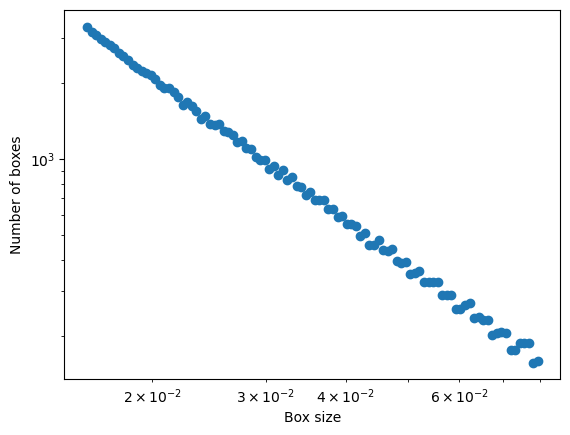

In [152]:
box_sizes = np.logspace(-1.8, -1.1, num=100) # range of box sizes from 0.01 to 1.0
dimension = box_counting_dimension(sort, box_sizes)
print('Box counting dimension:', dimension)

# Look at fractional brownian motion

In [153]:
from fbm import FBM
from gtda.time_series import SingleTakensEmbedding
import master

In [154]:
def get_coordinate(numbers):
    x = []
    y = []
    for num in numbers:
        x.append(num * np.cos(num))
        y.append(num * np.sin(num))
    return x, y

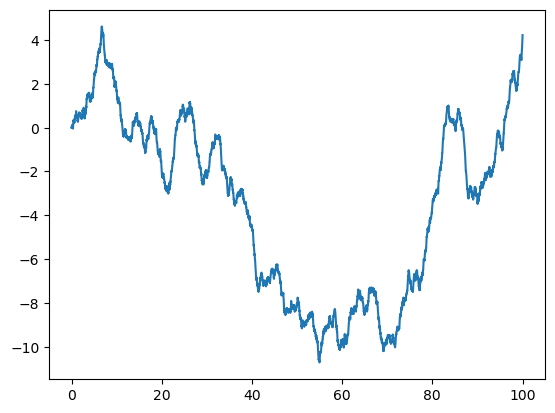

In [247]:
f = FBM(n=10000, hurst=0.763, length=100, method='daviesharte')

# Generate a fBm realization
fbm_sample = f.fbm()

# Get the times associated with the fBm
t_values = f.times()
plt.plot(t_values, fbm_sample)

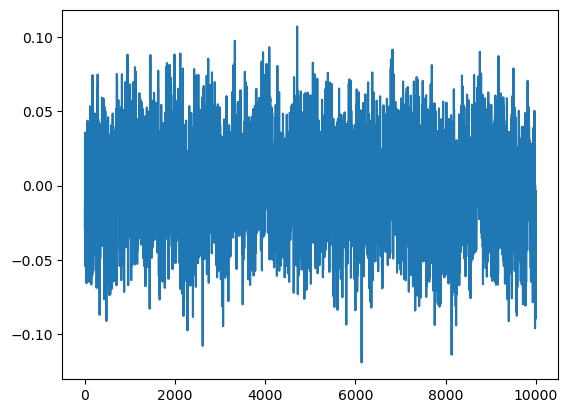

In [248]:
returns = []
returns = [fbm_sample[i]-fbm_sample[i+1] for i in range(len(fbm_sample)-1)]
plt.plot(returns)
plt.show()

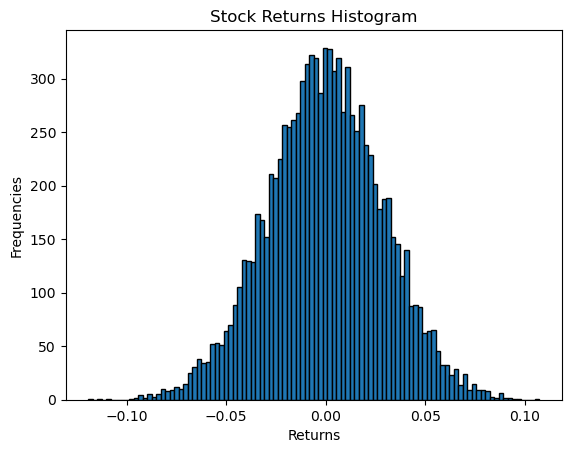

In [249]:
hist_values, bin_edges, _ = plt.hist(returns, bins=100, edgecolor='black')
midpoints = (bin_edges[:-1] + bin_edges[1:]) / 2
# Add labels and title
plt.xlabel('Returns')
plt.ylabel('Frequencies')
plt.title('Stock Returns Histogram')
plt.show()

In [250]:
#levy.fit_levy(hist_values)

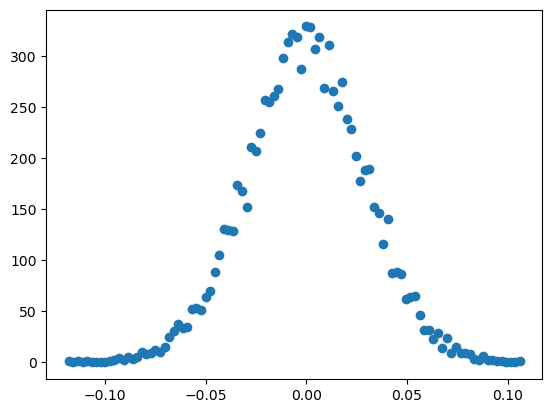

In [251]:
plt.scatter(midpoints, hist_values)
plt.show()

In [252]:
STE = SingleTakensEmbedding(parameters_type='search', dimension=2,
                            time_delay=20)
signal_embedded = STE.fit_transform(fbm_sample)
print('Optimal time delay based on mutual information:',
      STE.time_delay_)
print('Optimal embedding dimension based on false nearest neighbors:',
      STE.dimension_)

Optimal time delay based on mutual information: 20
Optimal embedding dimension based on false nearest neighbors: 2


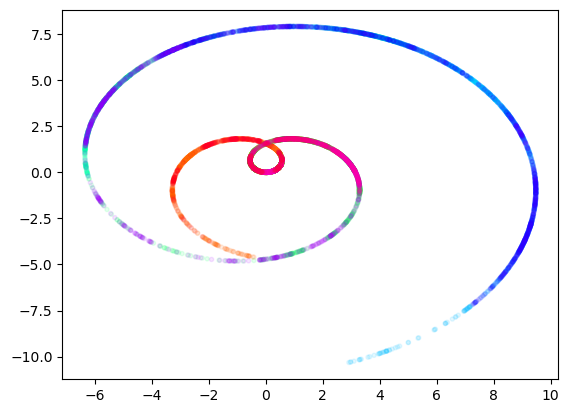

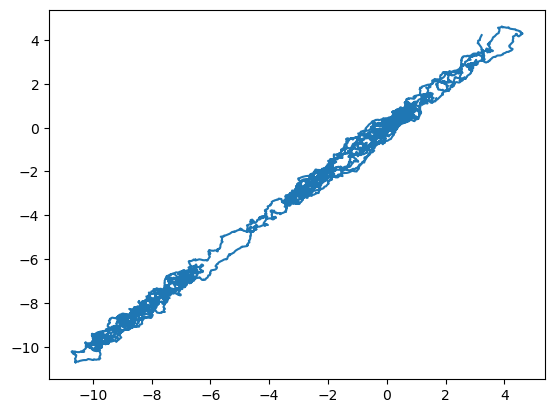

In [253]:
x_data, y_data = get_coordinate(fbm_sample)
plt.scatter(x_data, y_data, marker='.', c=t_values, cmap='hsv', alpha = 0.1)
plt.show()
plt.plot(signal_embedded[:,0], signal_embedded[:,1])
plt.show()

In [213]:
#Changing the length in f = FBM(n=10000, hurst=0.55, length=100, method='daviesharte')
# results in a creation of a spiral. The higher the length, the more present the spiral.
# explain this by looking at the function 'get_coordinates' which gets the circular coordinates

In [263]:
lengths = np.linspace(1,300, 10)
print(lengths)

[  1.          34.22222222  67.44444444 100.66666667 133.88888889
 167.11111111 200.33333333 233.55555556 266.77777778 300.        ]


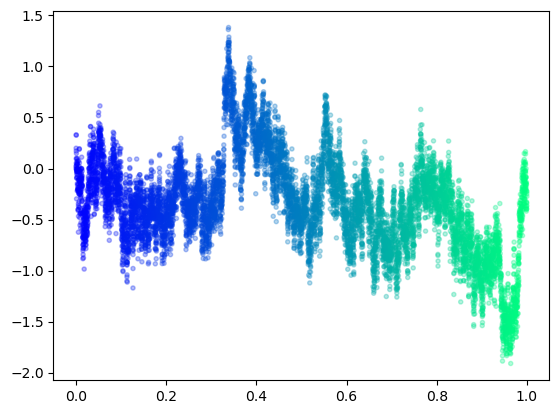

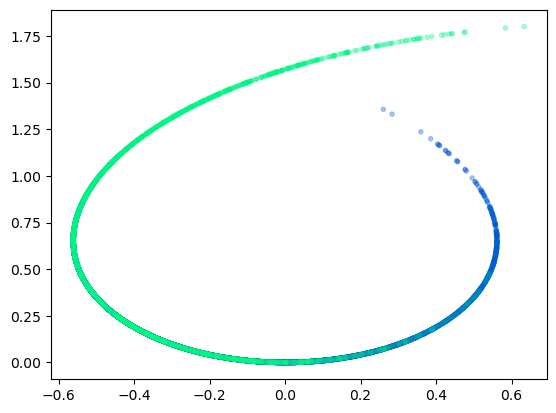

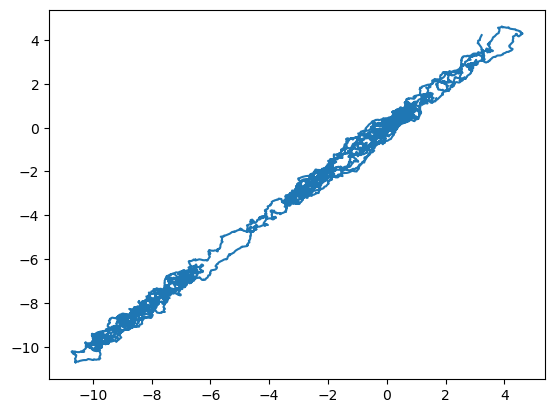

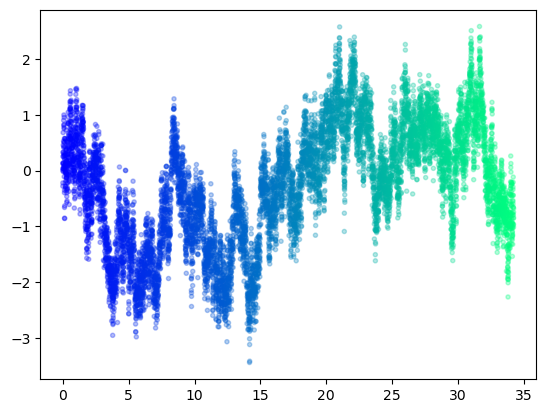

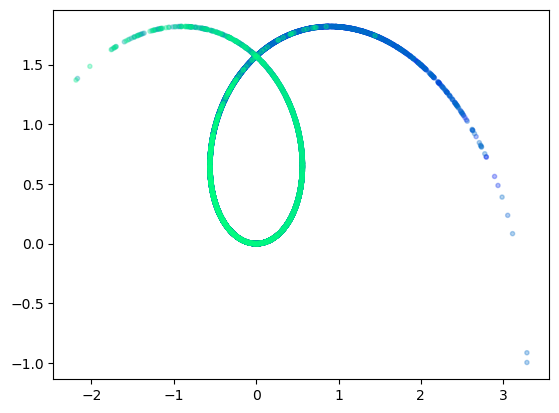

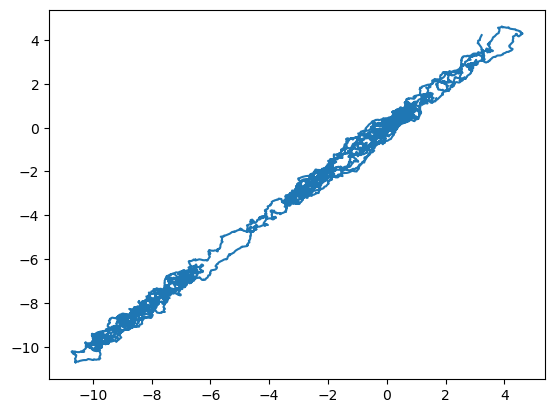

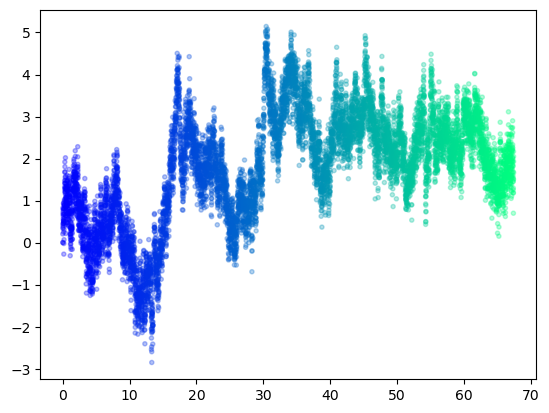

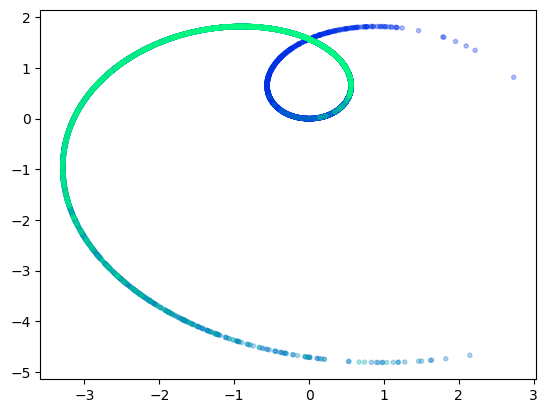

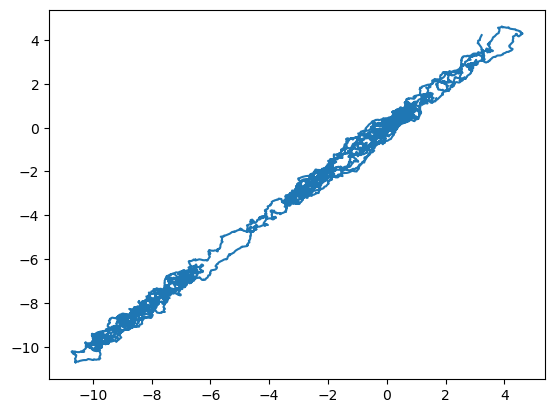

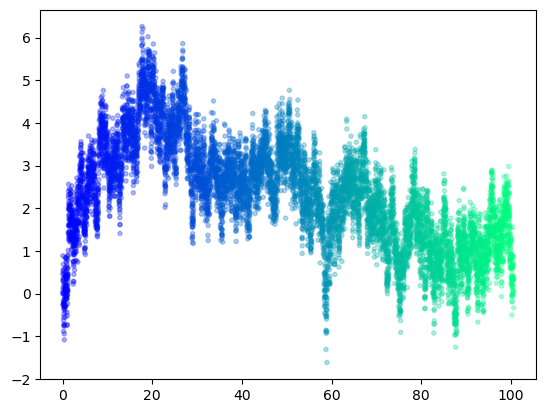

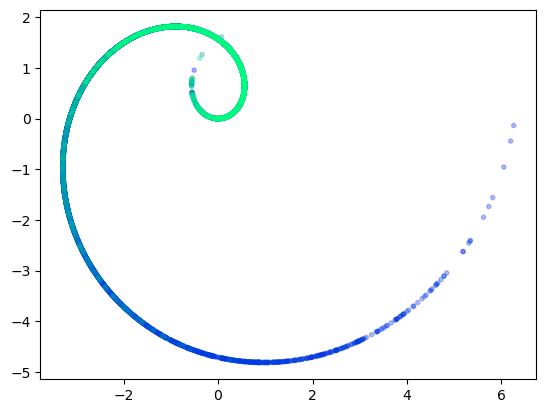

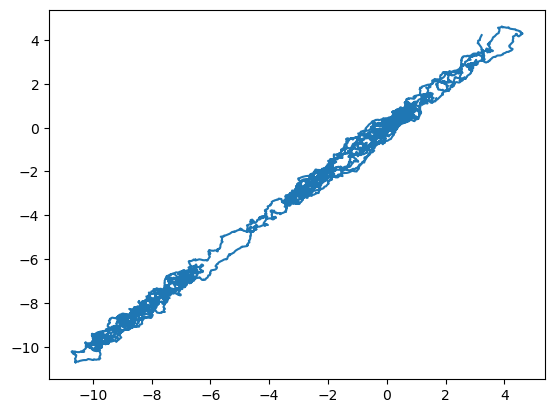

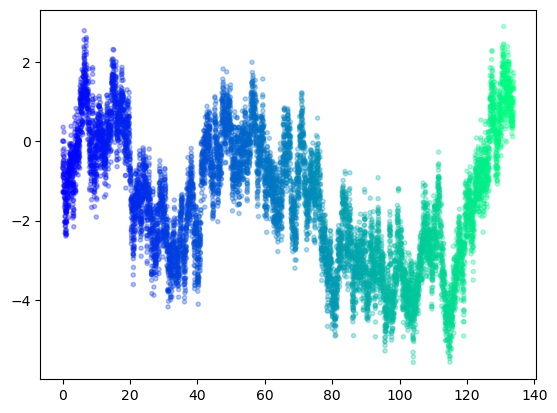

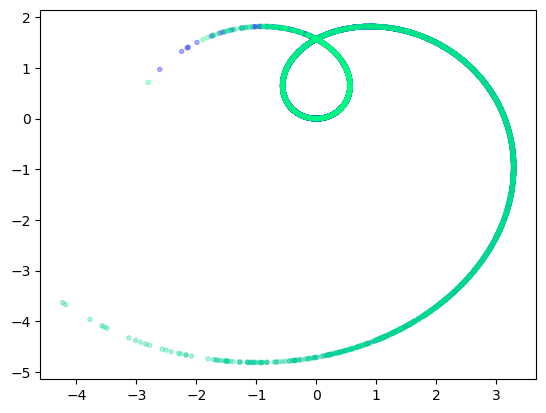

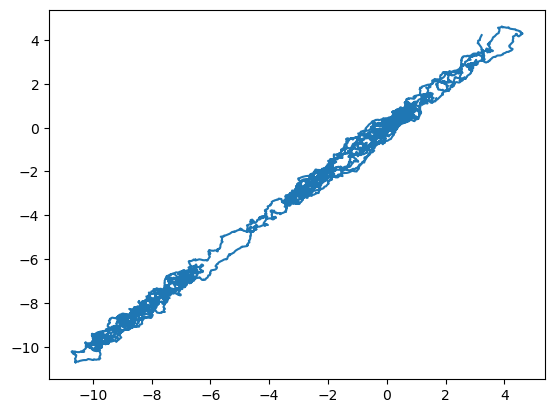

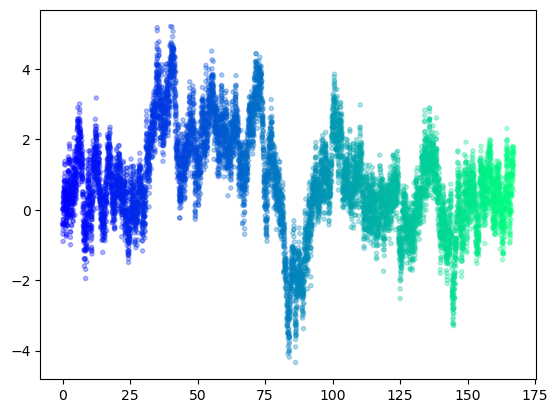

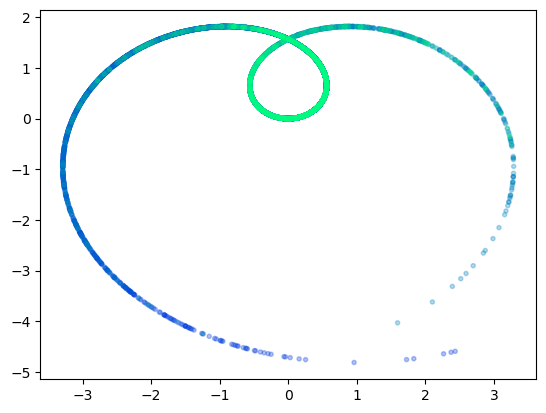

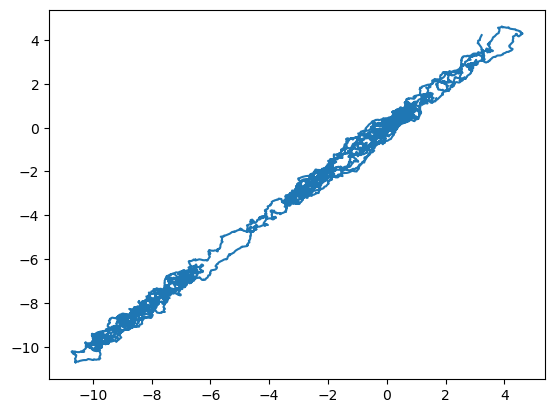

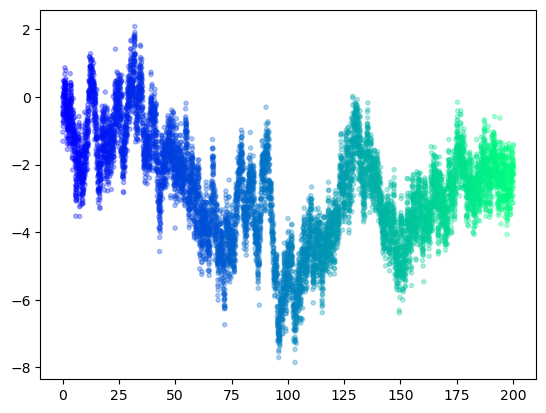

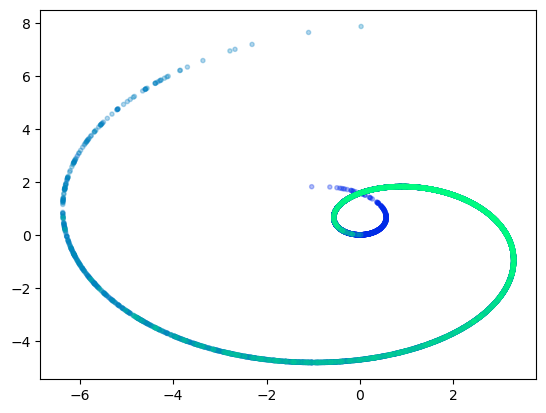

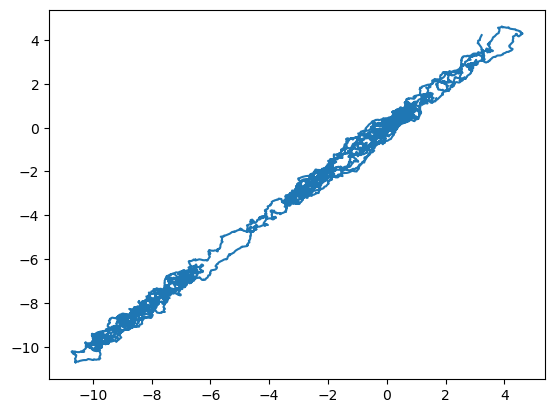

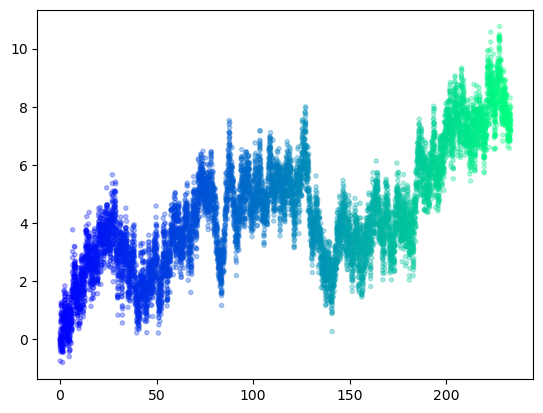

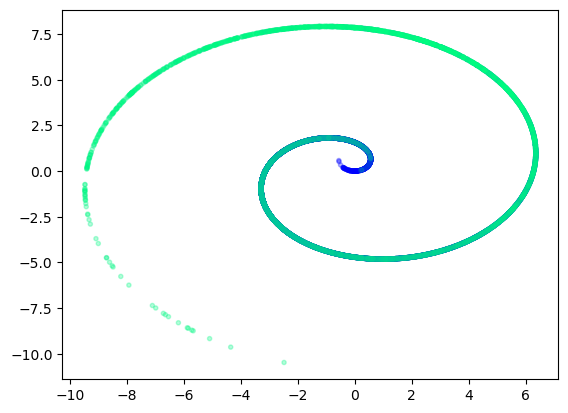

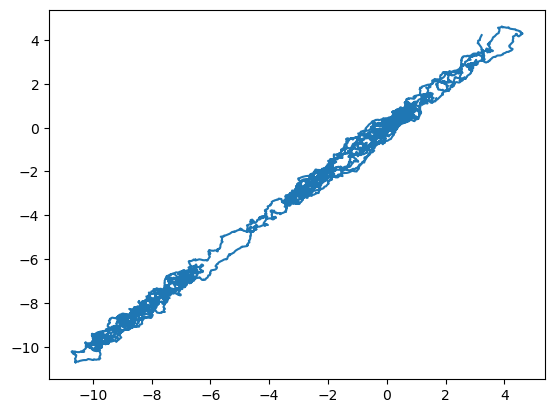

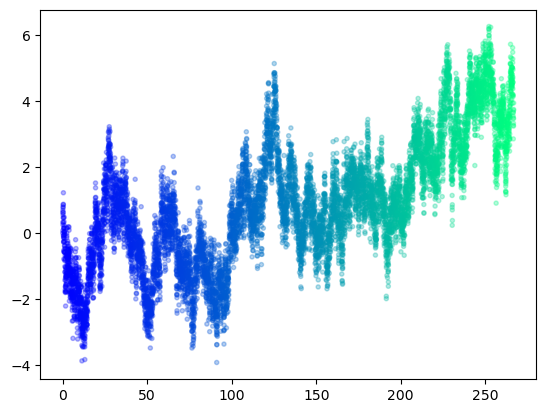

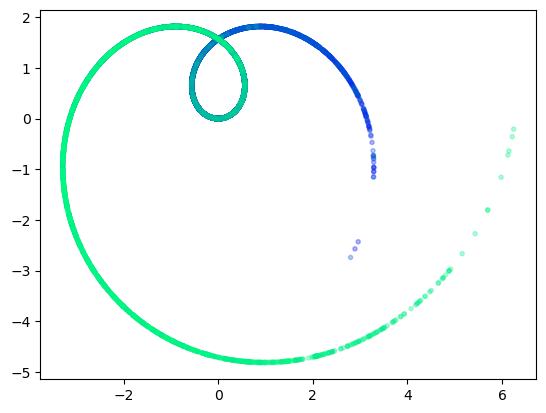

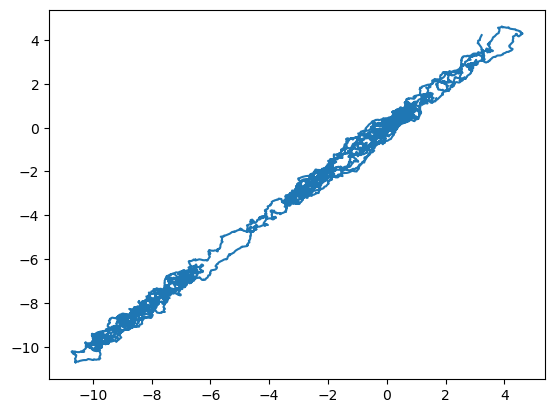

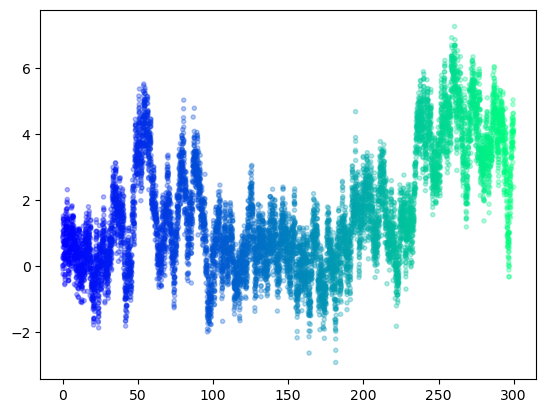

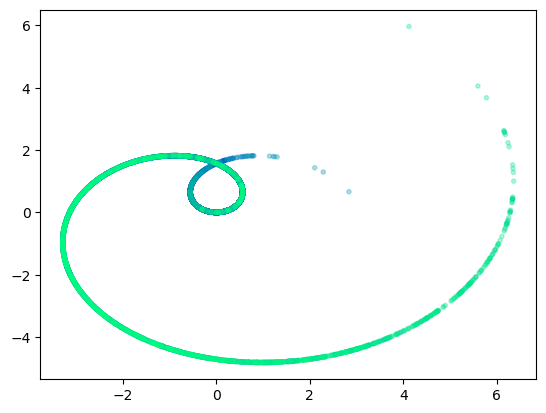

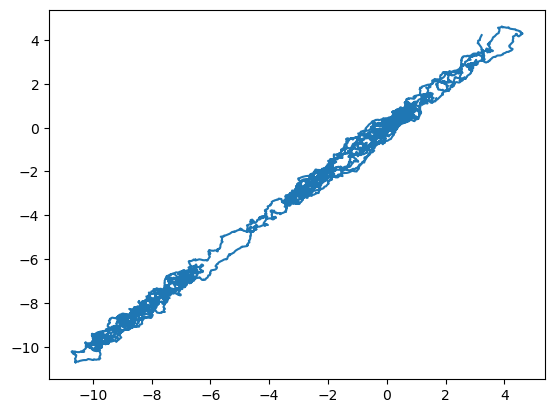

In [269]:
color_map = 'winter'
for length in lengths:
    f = FBM(n=10000, hurst=0.21, length=length, method='daviesharte')

    # Generate a fBm realization
    fbm_sample = f.fbm()

    # Get the times associated with the fBm
    t_values = f.times()
    plt.scatter(t_values, fbm_sample, marker='.', c=t_values, cmap=color_map, alpha = 0.3)
    plt.show()
    x_data, y_data = get_coordinate(fbm_sample)
    plt.scatter(x_data, y_data, marker='.', c=t_values, cmap=color_map, alpha = 0.3)
    plt.show()
    plt.plot(signal_embedded[:,0], signal_embedded[:,1])
    plt.show()

In [ ]:
# These plots visualizes the behavior of the fractional brownian in a different coordinate system.
# I think that at the right lenght (scale), a loop represents a sort of turning point (this is my hypothesis but this can be
# tested and verified with the formula of )

In [341]:
vals = np.linspace(1, 100, 300)

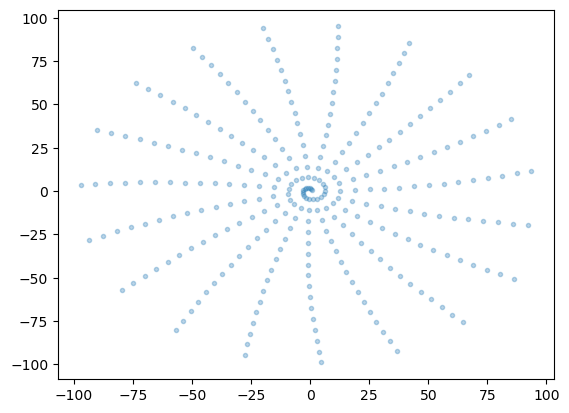

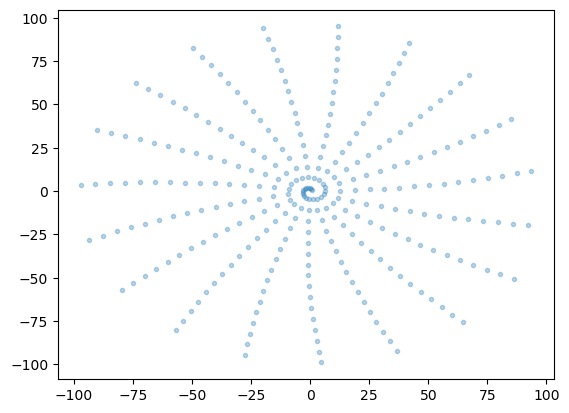

In [347]:
xs, ys = get_coordinate(vals)
plt.scatter(xs, ys, marker='.', alpha = 0.3)
plt.show()
xs, ys = get_coordinate(reversed(vals))
plt.scatter(xs, ys, marker='.', alpha = 0.3)
plt.show()